# Dataset Info

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- **cnt: count of total rental bikes including both casual and registered**
-------------------------

**categorical : season, hr, mnth, weekday, weathersit**
**Already Normalized: temp, hum, windspeed**
**For normalization : casual, registed, cnt**


# Target variable CNT


### Concept
  * Drop unnecessary high-correlated features, we must remove 'dteday' feature
  * Scale numerical featurs
  * Make one hot encoding to categorical features
  * Eliminate features that have corelation > 0.65 with the **target** feature "cnt"
  * Make neural network architecture
  * Save best weights with checkpoint
  * Load weights and use model.predict to visualize difference between test_targets and prediction_targets





In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing  
from keras.models import Sequential  # go koristime za da generirame sekvenca od sloevi vo nevronska mreza
from keras.layers import Dense, Activation # importirame celosno povrzuvacki sloj i aktivaciska funkicja(ne-linearnost)
from keras.utils import np_utils # pomosni funkcii (one-hot-encoding)
from keras.callbacks import ModelCheckpoint
 


# Read Dataset

In [0]:
path = 'hour.csv'
data = pd.read_csv(path)

# Print first 10 rows of the Dataset

In [156]:
data.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


# Calculate mean and std of cnt (Before scaling)

In [0]:
cnt_mean = data['cnt'].mean()  
cnt_std = data['cnt'].std()

In [158]:
print(cnt_mean)

189.46308763450142


In [159]:
print(cnt_std)

181.38759909186527


# Visualize data per day

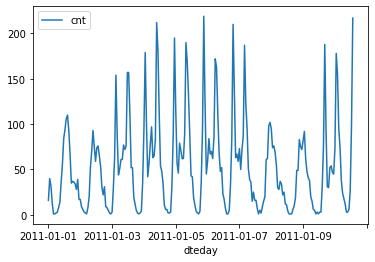

In [160]:
items_per_day = 24
days = 10

first_ten_dats = data[:items_per_day*days]

first_ten_dats.plot(x='dteday', y='cnt')

# Visualize features corelation

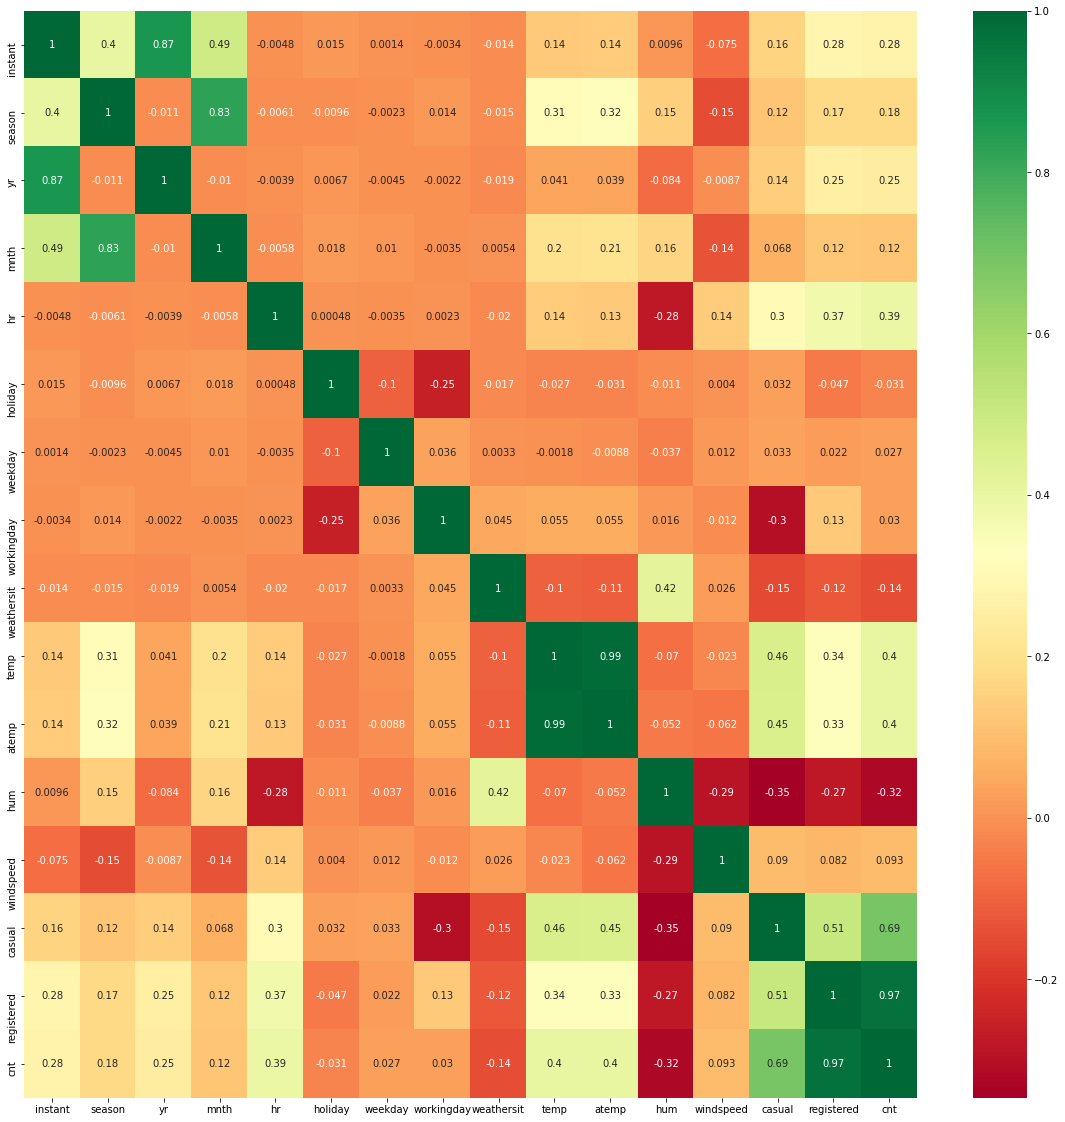

In [161]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(data[top_corr_features].corr(),
              annot=True,
              cmap="RdYlGn")

# Helper Methods

In [0]:
def make_one_hot_encoding(fields, data):
  """ Note : this method doesn't remove the original fields"""
  data_new = data.copy()
  for field in fields:
      one_hot_converted = pd.get_dummies(data[field], prefix=field, drop_first=False)
      data_new = pd.concat([data_new, one_hot_converted], axis=1)
  return data_new

def drop_fields(fields, data):
  data_new = data.copy()
  data_new = data_new.drop(fields, axis=1)
  return data_new

def scale_features(features, data):
  data_new = data.copy()
  scaler = preprocessing.StandardScaler()
  scaled_df = scaler.fit_transform(data_new[features])
  scaled_df = pd.DataFrame(scaled_df, columns=features)
  data_new.loc[:, features] = scaled_df
  return data_new


# Make One Hot Encoding

In [0]:
# one hot encoding here
fields = ['season', 'hr', 'mnth', 'weekday', 'weathersit']
data_one_hot = make_one_hot_encoding(fields, data)

# Drop fields with high correlation and the original fields that were  one hot encoded 
 * Also drop fields that are high correlated with *cnt (correlation>0.65)

In [0]:
fields = ['registered', 'casual', 'atemp','instant','dteday', 'season', 'hr', 'mnth', 'weekday', 'weathersit']
data_drop = drop_fields(fields, data_one_hot)

# Scale Features

* Scale features that are not previously scaled

In [0]:
fields = ['cnt']
data_scaled = scale_features(fields, data_drop)


# Print first 5 rows of the data

In [166]:
data_scaled.head(5)

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0,0.24,0.81,0.0,-0.956339,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0.22,0.80,0.0,-0.824022,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0.22,0.80,0.0,-0.868128,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,0,0,0,0.24,0.75,0.0,-0.972879,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0.24,0.75,0.0,-1.039037,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


# Data separation

* Split data between training set and test set
* Separate data between features and targets


In [0]:
test_data = data_scaled[-21*24:] 

train_data = data_scaled[:-21*24]

target_fields = ['cnt']

X_train, Y_train = train_data.drop(target_fields, axis=1), train_data[target_fields]
X_test, Y_test = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [168]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16875, 57)
(16875, 1)
(504, 57)
(504, 1)


# Define Neural network Architecture

In [194]:
# your NN Here


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128,input_dim = train_data.shape[1]-1, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 128)               7424      
_________________________________________________________________
dense_52 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_53 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_54 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 257       
Total params: 172,289
Trainable params: 172,289
Non-trainable params: 0
_________________________________________________________________


# Compile Model, specify loss, optimizer, and metrics

In [0]:
# Compile the network :
NN_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#NN_model.summary()

# Load best weights

In [0]:

checkpoint = ModelCheckpoint('best_modell.pt', monitor='val_mse', verbose = 1, save_best_only = True, mode ='min')
callbacks_list = [checkpoint]

# Fit the model : 
 * train the model on 20 epochs, 
 * save the best weights based on mse on each epoch

In [190]:
NN_model.fit(X_train, Y_train, 
             epochs=20, 
             batch_size=32, 
             callbacks=callbacks_list, 
             validation_data=(X_test, Y_test))


Train on 16875 samples, validate on 504 samples
Epoch 1/20
16875/16875 [==============================] - 2s 123us/step - loss: 0.1826 - mse: 0.1826 - val_loss: 0.2999 - val_mse: 0.2999

Epoch 00001: val_mse improved from inf to 0.29992, saving model to best_modell.pt
Epoch 2/20
16875/16875 [==============================] - 2s 107us/step - loss: 0.0781 - mse: 0.0781 - val_loss: 0.3354 - val_mse: 0.3354

Epoch 00002: val_mse did not improve from 0.29992
Epoch 3/20
16875/16875 [==============================] - 2s 106us/step - loss: 0.0684 - mse: 0.0684 - val_loss: 0.2012 - val_mse: 0.2012

Epoch 00003: val_mse improved from 0.29992 to 0.20115, saving model to best_modell.pt
Epoch 4/20
16875/16875 [==============================] - 2s 110us/step - loss: 0.0621 - mse: 0.0621 - val_loss: 0.2129 - val_mse: 0.2129

Epoch 00004: val_mse did not improve from 0.20115
Epoch 5/20
16875/16875 [==============================] - 2s 108us/step - loss: 0.0591 - mse: 0.0591 - val_loss: 0.2791 - val_ms

# Evaluation

In [0]:
targets = Y_test['cnt'].to_numpy() * cnt_std + cnt_mean
predictions = NN_model.predict(X_test).T * cnt_std + cnt_mean


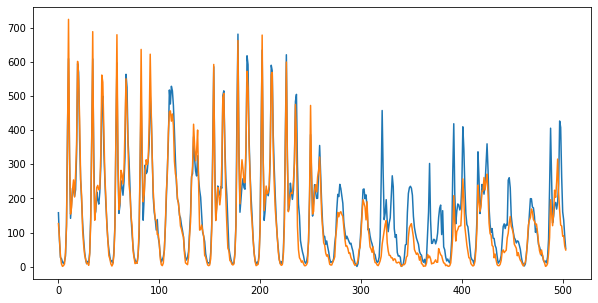

In [192]:
figure = plt.figure(figsize=(10,5))
plt.plot(predictions[0])
plt.plot(targets)

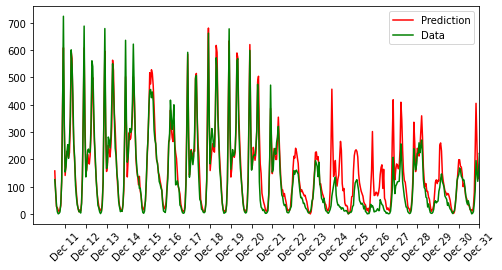

In [193]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(predictions[0], label='Prediction', color='red')
ax.plot((Y_test['cnt']*cnt_std + cnt_mean).values, label='Data', color='green')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(data.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)